In this notebook, we will put together a full fledged training logic. This notebook will run on the Kaggle GPU. The advantage of using Kaggle is that we can schedule the notebook for a run whenever it finds a new version of the dataset it is associated with. 

In [1]:
! pip install huggingface_hub["fastai"]

## Set up

In [3]:
import wandb
from fastai.vision.all import *
from fastai.callback.wandb import WandbCallback
from huggingface_hub import notebook_login, push_to_hub_fastai, from_pretrained_fastai

In [4]:
trn_path = '/kaggle/input/ideitify'
files = get_image_files(trn_path)

In [5]:
set_seed(42, reproducible=True)

## Wandb for tracking experiment

 Wandb is a MLOps platform that allows you to track and visualize your machine learning experiments, from data preprocessing to model training and evaluation. You can easily log your experiments and compare results across different runs or models, as well as collaborate with team members and share your work with the wider community. Wandb also offers features like hyperparameter optimization, model checkpoints, and experiment reproduction, making it a great all-in-one solution for managing deep learning projects.

In [6]:
WANDB_PROJECT = 'Ideitify'

wandb project: a lower-level grouping that contains a set of related experiments. Each project has its own set of experiment runs, visualizations, and configurations. Projects are typically used to represent a specific machine learning project or experiment.

In [10]:
config = SimpleNamespace(
    seed=42,
    batch_size=256,
    epochs=25,
    pre_size=256,
    img_size=224,
    resize_method="squish",
    model_name="vit_small_patch32_224",
    learning_rate=1.5e-2,
    wandb_project=WANDB_PROJECT,
)

In [11]:
metrics = [error_rate, accuracy, partial(top_k_accuracy, k=3), partial(top_k_accuracy, k=5)]

In [12]:
cbs=[
    MixUp(1.),
    SaveModelCallback(monitor="accuracy"),
    WandbCallback(log_preds=False, log_model=True)
]

## Train the model

In [13]:
with wandb.init(project=WANDB_PROJECT, config=config):
    config = wandb.config
    
    dls = ImageDataLoaders.from_folder(
        trn_path, valid_pct=0.2, 
        seed=config.seed, bs=config.batch_size,
        item_tfms=Resize(config.pre_size, method=config.resize_method), 
        batch_tfms=aug_transforms(size=config.img_size, min_scale=0.75), 
    )

    learn = vision_learner(
        dls, arch=config.model_name, 
        loss_func=LabelSmoothingCrossEntropy(), 
        metrics=metrics, path='.').to_fp16()
    
    learn.fine_tune(config.epochs, config.learning_rate, cbs=cbs)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,top_k_accuracy,time
0,3.909103,2.310877,0.589206,0.410794,0.650159,0.744127,02:22


Better model found at epoch 0 with accuracy value: 0.410793662071228.


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,top_k_accuracy,time
0,2.898461,2.018924,0.487619,0.512381,0.724444,0.826032,02:17
1,2.776018,1.892758,0.441270,0.558730,0.764444,0.845079,02:20
2,2.655759,1.796413,0.398730,0.601270,0.794286,0.872381,02:15
3,2.557430,1.691396,0.372063,0.627936,0.826032,0.896508,02:20
4,2.482965,1.652790,0.352381,0.647619,0.824127,0.893968,02:18
5,2.429463,1.578633,0.334603,0.665397,0.843175,0.909206,01:39
6,2.371869,1.543691,0.323810,0.676190,0.845714,0.916191,01:19
7,2.322434,1.501680,0.313016,0.686984,0.871111,0.918095,01:20
8,2.276436,1.486131,0.295873,0.704127,0.863492,0.926349,01:19
9,2.224242,1.442381,0.275556,0.724444,0.876190,0.926349,01:20


Better model found at epoch 0 with accuracy value: 0.5123809576034546.
Better model found at epoch 1 with accuracy value: 0.5587301850318909.
Better model found at epoch 2 with accuracy value: 0.6012698411941528.
Better model found at epoch 3 with accuracy value: 0.6279364824295044.
Better model found at epoch 4 with accuracy value: 0.6476190686225891.
Better model found at epoch 5 with accuracy value: 0.6653968095779419.
Better model found at epoch 6 with accuracy value: 0.6761904954910278.
Better model found at epoch 7 with accuracy value: 0.686984121799469.
Better model found at epoch 8 with accuracy value: 0.7041270136833191.
Better model found at epoch 9 with accuracy value: 0.7244444489479065.
Better model found at epoch 10 with accuracy value: 0.7295238375663757.
Better model found at epoch 11 with accuracy value: 0.7517460584640503.
Better model found at epoch 12 with accuracy value: 0.7587301731109619.
Better model found at epoch 14 with accuracy value: 0.7650793790817261.
Bet

accuracy,▁▃▄▅▅▅▆▆▆▆▇▇▇▇▇███████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
error_rate,█▆▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
lr_0,▃█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▃█▂▂▂▃▃▄▄▅▅▆▆▆▆▆▆▆▅▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁
mom_0,▇▃██▇▇▆▅▄▃▂▁▁▁▁▁▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇█████
mom_1,▇▃██▇▇▆▅▄▃▂▁▁▁▁▁▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇█████
raw_loss,█▆▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▁▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


## Interpretation

In [14]:
interp = ClassificationInterpretation.from_learner(learn)

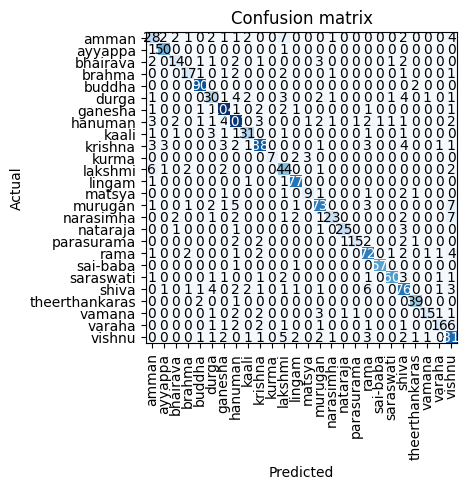

In [15]:
interp.plot_confusion_matrix()

## Sharing model to Hugging Face hub

The Hub is a central platform where anyone can share and explore models, datasets, and ML demos. It has the most extensive collection of Open Source models, datasets, and demos.

Sharing the model on the Hub allows us to use huggingface inference api as our backend service. we can easily integrate it with our streamlit app.

In [16]:
notebook_login()

In [18]:
repo_id = "Yegyanathan/Ideitify"

push_to_hub_fastai(learner=learn, repo_id=repo_id)

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

model.pkl:   0%|          | 0.00/91.0M [00:00<?, ?B/s]

'https://huggingface.co/Yegyanathan/Ideitify/tree/main/'

## Loading model from the Hugging Face Hub for inference

In [19]:
learn = from_pretrained_fastai(repo_id)

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

## Test time augmentation for inference

In [34]:
valid = dls.valid
preds, targs = learn.get_preds(dl=valid)

In [35]:
print(error_rate(preds, targs))
print(accuracy(preds, targs))
print(top_k_accuracy(preds, targs, 3))
print(top_k_accuracy(preds, targs, 5))

TensorBase(0.2121)
TensorBase(0.7879)
tensor(0.9111)
tensor(0.9498)


In [36]:
valid = dls.valid
tta_preds, targs = learn.tta(dl=valid)

In [39]:
print(error_rate(tta_preds, targs))
print(accuracy(tta_preds, targs))
print(top_k_accuracy(tta_preds, targs, 3))
print(top_k_accuracy(tta_preds, targs, 5))

TensorBase(0.1860)
TensorBase(0.8140)
tensor(0.9276)
tensor(0.9651)


Final metrics on the validation set after TTA..